# Task 1: Exploratory Data Analysis (EDA)

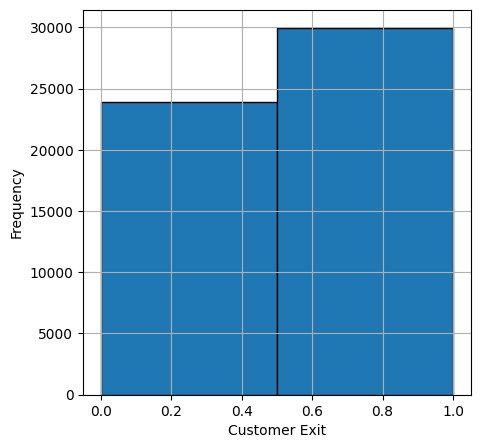

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Customer = pd.read_csv("customer_exit.csv")

Customer["customer_exit"].hist(bins=2, edgecolor='black', figsize=(5, 5))
plt.xlabel('Customer Exit')
plt.ylabel('Frequency')
plt.show()

The chart above shows that more customers left than stayed.

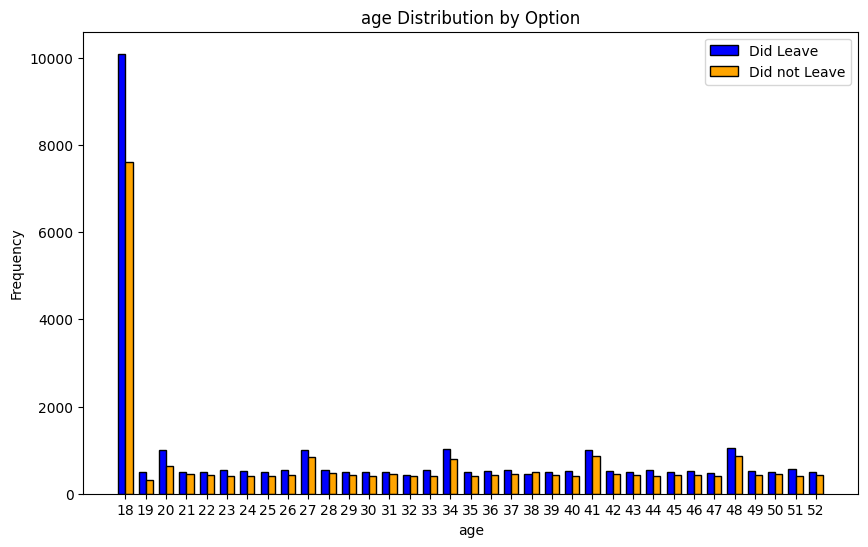

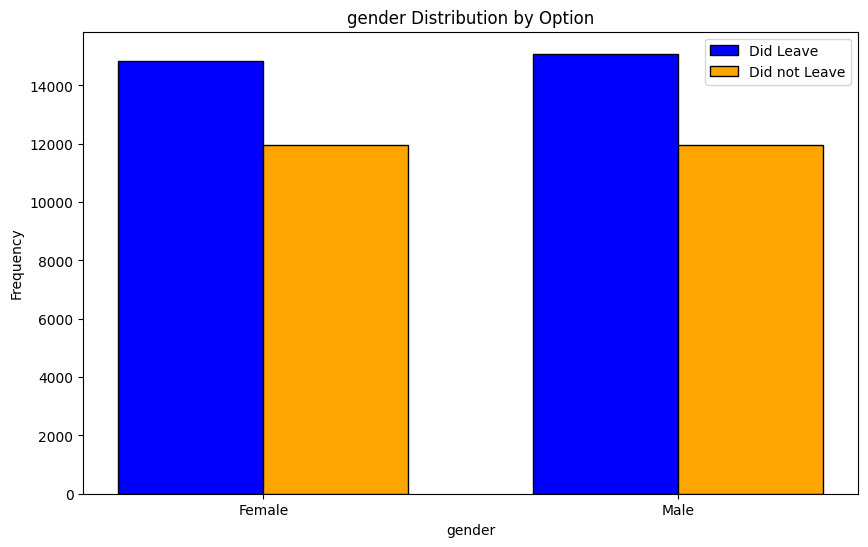

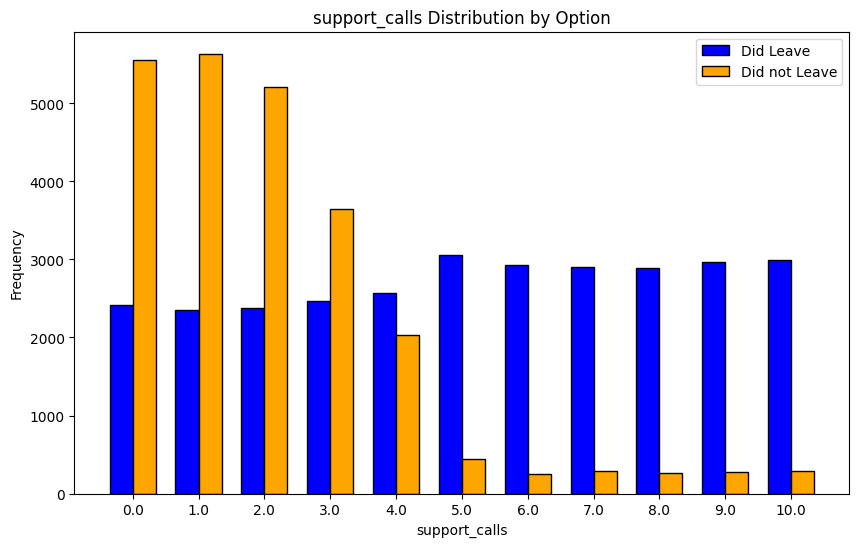

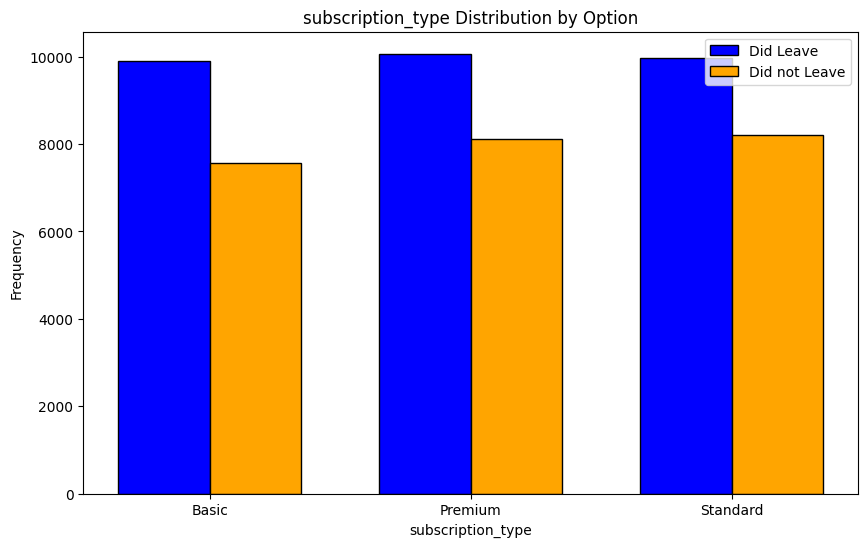

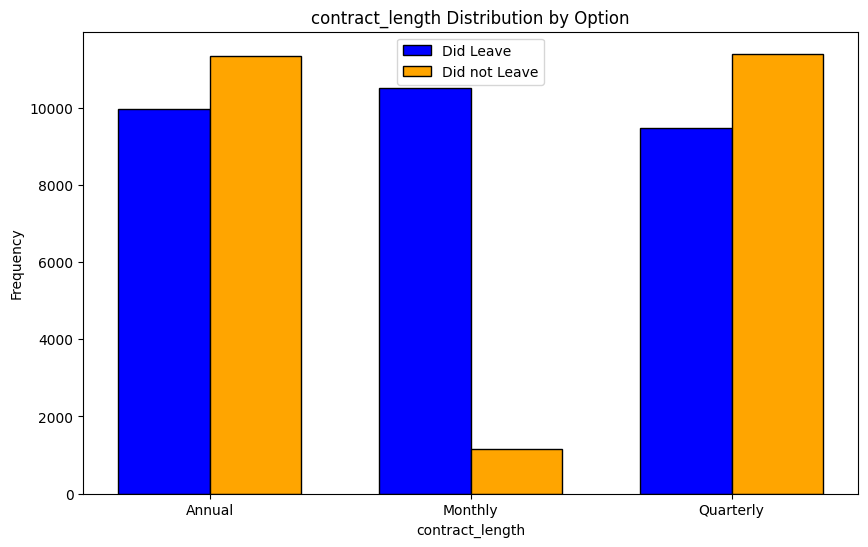

In [ ]:
from pandas.plotting import scatter_matrix

def compare(feature):
  feature_option1 = Customer[Customer['customer_exit'] == 1.0][feature]
  feature_option0 = Customer[Customer['customer_exit'] == 0.0][feature]

  feature_groups = sorted(Customer[feature].unique())
  counts_option1 = [feature_option1.tolist().count(age) for age in feature_groups]
  counts_option0 = [feature_option0.tolist().count(age) for age in feature_groups]

  bar_width = 0.35
  x = np.arange(len(feature_groups))
  plt.figure(figsize=(10,6))
  plt.bar(x - bar_width/2, counts_option1, width=bar_width, label='Did Leave', color='blue', edgecolor='black')
  plt.bar(x + bar_width/2, counts_option0, width=bar_width, label='Did not Leave', color='orange', edgecolor='black')

  plt.xlabel(feature)
  plt.ylabel('Frequency')
  plt.title(feature + ' Distribution by Option')
  plt.xticks(x, feature_groups)

  plt.legend()
  plt.show()

compare('age')
compare('gender')
compare('support_calls')
compare('subscription_type')
compare('contract_length')


Of the features in the data, the ones shown above held the most valuable informaation regarding the data. Important patterns to recognize are as follows:


*   There is no correlation between gender and termination of service.
*   The number of support calls made did not affect the number of members that left, but did affect the number of members that stayed. As the number of support calls increased, less customers continued using the service.
*   There is no correlation between subscription type and termination of service.
*   There is a correlation between contract length and termination of service. When the user made a monthly contract, they were much less likely to stay with using the service.


In [ ]:
missing_values = Customer.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
age                    0
gender                 0
membership_duration    0
usage_frequency        0
support_calls          0
payment_delay          0
subscription_type      0
contract_length        0
cumulative_charges     0
last_interaction       0
customer_exit          0
dtype: int64


The chart above shows the number of null values for every column. Since there are no null values in any column, there is no missing information.

# Task 2: Data Preprocessing with Pipelines and Feature Extraction

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

features = Customer.drop('customer_exit', axis=1)
target = Customer['customer_exit']

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(Customer, Customer["customer_exit"]):
  strat_train_set = Customer.iloc[train_index]
  strat_test_set = Customer.iloc[test_index]

strat_test_set["customer_exit"].value_counts() / len(strat_test_set)
strat_train_set["customer_exit"].value_counts() / len(strat_train_set)

train = strat_train_set.drop("customer_exit", axis=1)
train_labels = strat_train_set["customer_exit"].copy()

test = strat_test_set.drop("customer_exit", axis=1)
test_labels = strat_test_set["customer_exit"].copy()

num_std_attribs = ['age', 'usage_frequency', 'membership_duration', 'support_calls', 'payment_delay', 'cumulative_charges', 'last_interaction']
cat_attribs = ['gender', 'subscription_type', 'contract_length']

std_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
    ('stdscaler', StandardScaler()),
])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
 ('onehot', OneHotEncoder())])

def fit_and_print(p, train_set, train_labels, test_set, test_labels):
  p.fit(train_set, train_labels)
  train_preds = p.predict(train_set)
  test_preds = p.predict(test_set)
  print("Training Error MAE: " + str(mean_absolute_error(train_preds, train_labels)))
  print("Test Error MAE: " + str(mean_absolute_error(test_preds, test_labels)))
  print("R2 score: " + str(r2_score(test_preds, test_labels)))

NameError: name 'Customer' is not defined

Above is the data processing that will be used for the machine. Furthermore, the function to fit and print a project is also stated at the bottom.

In [ ]:
from sklearn.compose import ColumnTransformer

full_transformer = ColumnTransformer([('numeric_stdpreprocessing', std_pipeline, num_std_attribs),
                                 ('cat_preprocessing', cat_pipeline, cat_attribs)
                                ])

p1_full_pipeline = Pipeline([('all_column_transformation', full_transformer),
                        ('linear_regression', LinearRegression())
                      ])

fit_and_print(p1_full_pipeline, train, train_labels, test, test_labels)

Training Error MAE: 0.3072148038640339
Test Error MAE: 0.3077724464573065
R2 score: -0.26387900987290025


Since the error is relatively low, our model is performing decently well. The similarity in both errors suggests that we are not suffering from overfitting or underfitting. The negative R2 score tells us that the model is not finding adequate patterns.

# Task 3: Train Classification Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forestProcessor = ColumnTransformer([('numeric_stdpreprocessing', std_pipeline, num_std_attribs),
                                 ('cat_preprocessing', cat_pipeline, cat_attribs)
                                ])

tree_pipeline = Pipeline([
    ('treeProcessor', forestProcessor),
    ('tree', RandomForestClassifier(random_state=42))
])

fit_and_print(tree_pipeline, train, train_labels, test, test_labels)


Training Error MAE: 0.0
Test Error MAE: 0.09602526002971769
R2 score: 0.6065253095790191


Showing that there was absolutely no training error, there is a serious amount of overfitting that is occurring due to the Random Forest Classifier. This also explains the high R2 score. This model was also the fastest model to run.

In [ ]:
from sklearn.linear_model import LogisticRegression

linearProcessor = ColumnTransformer([('numeric_stdpreprocessing', std_pipeline, num_std_attribs),
                                 ('cat_preprocessing', cat_pipeline, cat_attribs)
                                ])

log_pipeline = Pipeline([
    ('Processor', linearProcessor),
    ('tree', LogisticRegression(random_state=42))
])

fit_and_print(log_pipeline, train, train_labels, test, test_labels)


Training Error MAE: 0.15527849365001972
Test Error MAE: 0.15648216939078752
R2 score: 0.3723494299073348


The training and testing error is very close, which means we have a reliable machine. However, the low R2 score shows that it is not a very accurate machine. This model was also the second fastest to run.

In [ ]:
from sklearn.svm import SVC

SVC_clf = ColumnTransformer([('numeric_stdpreprocessing', std_pipeline, num_std_attribs),
                                 ('cat_preprocessing', cat_pipeline, cat_attribs)
                                ])

SVC_pipeline = Pipeline([
    ('SVCProcessor', SVC_clf),
    ('SVC', SVC(random_state=42, probability = True))
])

fit_and_print(SVC_pipeline, train, train_labels, test, test_labels)

The Support Vector Classifier did not run in time for this project to be submitted. It took over four hours of running and it did not even finish. I had to cut my losses and continue with the rest of the project. However, I have come to the conclusion that the SVC works much better with smaller datasets and his very resistent to outliers.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = ColumnTransformer([('numeric_stdpreprocessing', std_pipeline, num_std_attribs),
                                 ('cat_preprocessing', cat_pipeline, cat_attribs)
                                ])

bag_pipeline = Pipeline([
    ('bagging_classifier', bag_clf),
    ('bag', BaggingClassifier(estimator=RandomForestClassifier(random_state=42), random_state=42))
])

fit_and_print(bag_pipeline, train, train_labels, test, test_labels)

Training Error MAE: 0.04615634649764343
Test Error MAE: 0.09667533432392274
R2 score: 0.6041614315419426


For the Bagging Classifier, the R2 score was very large and the training/testing data were relatively similar. This model took about ten minutes to fully run. Of all the models so far, this one tests the best.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_processor = ColumnTransformer([('numeric_stdpreprocessing', std_pipeline, num_std_attribs),
                                 ('cat_preprocessing', cat_pipeline, cat_attribs)
                                 ])

vote_pipeline = Pipeline([
    ('ada_classifier', ada_processor),
    ('ada', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, learning_rate=0.5, random_state=42, algorithm='SAMME.R'
))
])

fit_and_print(vote_pipeline, train, train_labels, test, test_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training Error MAE: 0.13682059854658588
Test Error MAE: 0.13270802377414562
R2 score: 0.46812858208058594


The Ada Boost Classifier did very well with keeping the training and testing data similar. It also kept its R2 score relatively high, although not as high as the Bagging Classifier. This model took from 10-15 minutes to run.

# Task 4: Model Evaluation


**Random Forest Classifier**

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score

# Get accuracy score with cross-validation
accuracy_scores = cross_val_score(tree_pipeline, train, train_labels, cv=3, scoring="accuracy")
print(f"Cross-Validated Accuracy Score: {accuracy_scores.mean()}")

# Predict using the model on the training set
y_train_pred = tree_pipeline.predict(train)

# Confusion matrix
cm = confusion_matrix(train_labels, y_train_pred)
tn, fp, fn, tp = cm.ravel()

# Print metrics
accuracy_score = (tp + tn) / (tp + tn + fp + fn)
specificity_score = tn / (tn + fp)

print(f"Accuracy Score: {accuracy_score}")
print(f"Precision Score: {precision_score(train_labels, y_train_pred)}")
print(f"Recall Score: {recall_score(train_labels, y_train_pred)}")
print(f"Specificity Score: {specificity_score}")
print(f"F1 Score: {f1_score(train_labels, y_train_pred)}")


Cross-Validated Accuracy Score: 0.902045459822154
Accuracy Score: 1.0
Precision Score: 1.0
Recall Score: 1.0
Specificity Score: 1.0
F1 Score: 1.0


All the scores here are shown as 1.0. This is a sure sign of overfitting, which was theorized when looking at the training and testing errors. Thus, this model did not do well compared to the others.

**Logistic Regression**

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score

# Get accuracy score with cross-validation
accuracy_scores = cross_val_score(log_pipeline, train, train_labels, cv=3, scoring="accuracy")
print(f"Cross-Validated Accuracy Score: {accuracy_scores.mean()}")

# Predict using the model on the training set
y_train_pred = log_pipeline.predict(train)

# Confusion matrix
cm = confusion_matrix(train_labels, y_train_pred)
tn, fp, fn, tp = cm.ravel()

# Print metrics
accuracy_score = (tp + tn) / (tp + tn + fp + fn)
specificity_score = tn / (tn + fp)

print(f"Accuracy Score: {accuracy_score}")
print(f"Precision Score: {precision_score(train_labels, y_train_pred)}")
print(f"Recall Score: {recall_score(train_labels, y_train_pred)}")
print(f"Specificity Score: {specificity_score}")
print(f"F1 Score: {f1_score(train_labels, y_train_pred)}")


Cross-Validated Accuracy Score: 0.8446286364375103
Accuracy Score: 0.8447215063499802
Precision Score: 0.8740843483160677
Recall Score: 0.8420393335838657
Specificity Score: 0.8480807446919778
F1 Score: 0.8577626541897065


Having all scores be above 80% is a good sign. Meaning this model is very reliable in its predictions.

**Support Vector Classification**

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score

# Get accuracy score with cross-validation
accuracy_scores = cross_val_score(SVC_pipeline, train, train_labels, cv=3, scoring="accuracy")
print(f"Cross-Validated Accuracy Score: {accuracy_scores.mean()}")

# Predict using the model on the training set
y_train_pred = SVC_pipeline.predict(train)

# Confusion matrix
cm = confusion_matrix(train_labels, y_train_pred)
tn, fp, fn, tp = cm.ravel()

# Print metrics
accuracy_score = (tp + tn) / (tp + tn + fp + fn)
specificity_score = tn / (tn + fp)

print(f"Accuracy Score: {accuracy_score}")
print(f"Precision Score: {precision_score(train_labels, y_train_pred)}")
print(f"Recall Score: {recall_score(train_labels, y_train_pred)}")
print(f"Specificity Score: {specificity_score}")
print(f"F1 Score: {f1_score(train_labels, y_train_pred)}")


The SVC model was not able to give a testing/training score in time, so it is hard to say whether this model did what it was supposed to. We can predict that in the amount of time it was taking to test, that it must have been doing relatively well.

**Bagging Classifier**

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score

# Get accuracy score with cross-validation
accuracy_scores = cross_val_score(bag_pipeline, train, train_labels, cv=3, scoring="accuracy")
print(f"Cross-Validated Accuracy Score: {accuracy_scores.mean()}")

# Predict using the model on the training set
y_train_pred = bag_pipeline.predict(train)

# Confusion matrix
cm = confusion_matrix(train_labels, y_train_pred)
tn, fp, fn, tp = cm.ravel()

# Print metrics
accuracy_score = (tp + tn) / (tp + tn + fp + fn)
specificity_score = tn / (tn + fp)

print(f"Accuracy Score: {accuracy_score}")
print(f"Precision Score: {precision_score(train_labels, y_train_pred)}")
print(f"Recall Score: {recall_score(train_labels, y_train_pred)}")
print(f"Specificity Score: {specificity_score}")
print(f"F1 Score: {f1_score(train_labels, y_train_pred)}")


Cross-Validated Accuracy Score: 0.9013721529567458
Accuracy Score: 0.9538436535023566
Precision Score: 0.9481653810048569
Recall Score: 0.9700196250365359
Specificity Score: 0.9335843531011401
F1 Score: 0.958968008255934


With all scores above 90%, the bagging classifier performed excellently compared to the other models. This model proved to be the most reliable out of the many.

**Ada Boost Classifier**

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score

# Get accuracy score with cross-validation
accuracy_scores = cross_val_score(vote_pipeline, train, train_labels, cv=3, scoring="accuracy")
print(f"Cross-Validated Accuracy Score: {accuracy_scores.mean()}")

# Predict using the model on the training set
y_train_pred = vote_pipeline.predict(train)

# Confusion matrix
cm = confusion_matrix(train_labels, y_train_pred)
tn, fp, fn, tp = cm.ravel()

# Print metrics
accuracy_score = (tp + tn) / (tp + tn + fp + fn)
specificity_score = tn / (tn + fp)

print(f"Accuracy Score: {accuracy_score}")
print(f"Precision Score: {precision_score(train_labels, y_train_pred)}")
print(f"Recall Score: {recall_score(train_labels, y_train_pred)}")
print(f"Specificity Score: {specificity_score}")
print(f"F1 Score: {f1_score(train_labels, y_train_pred)}")


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Cross-Validated Accuracy Score: 0.8624828771098884
Accuracy Score: 0.8631794014534141
Precision Score: 0.8971493929262714
Recall Score: 0.8515595640736565
Specificity Score: 0.877732454764146
F1 Score: 0.8737602022236027


The Ada Boost model performed exceptionally well and did not take nearly as long as the SVC. Therefore, this model is a good choice.

# Task 5: Hyperparameter Tuning with GridSearchCV


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [10, 50, 100],  # Number of base estimators
    'max_samples': [0.5, 0.7, 1.0],  # Fraction of samples to use per base estimator
    'max_features': [0.5, 0.7, 1.0],  # Fraction of features to use per base estimator
    'bootstrap': [True, False],  # Whether to sample with replacement
    'n_jobs': [-1]  # Use all processors for parallelization
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(bag_pipeline, param_grid, cv=5)

# Perform the grid search
grid_search.fit(train, train_labels)

print("Best parameters found:")
print(grid_search.best_params_)

ValueError: Invalid parameter 'bootstrap' for estimator Pipeline(steps=[('bagging_classifier',
                 ColumnTransformer(transformers=[('numeric_stdpreprocessing',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'usage_frequency',
                                                   'membership_duration',
                                                   'support_calls',
                                                   'payment_delay',
                                                   'cumulative_charges',
                                                   'last_interaction']),
                                                 ('cat_preprocessing',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['gender',
                                                   'subscription_type',
                                                   'contract_length'])])),
                ('bag',
                 BaggingClassifier(estimator=RandomForestClassifier(random_state=42),
                                   random_state=42))]). Valid parameters are: ['memory', 'steps', 'verbose'].

The grid search showed that the parameters provided were the best possible outcome, so there is no adjustment required for Bagging Classifier 2.0.

In [ ]:
#AdaBoost Classifier 2.0
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = ColumnTransformer([('numeric_stdpreprocessing', std_pipeline, num_std_attribs),
                                 ('cat_preprocessing', cat_pipeline, cat_attribs)
                                ])

bag_pipeline = Pipeline([
    ('bagging_classifier', bag_clf),
    ('bag', BaggingClassifier(estimator=RandomForestClassifier(random_state=42), random_state=42))
])

fit_and_print(bag_pipeline, train, train_labels, test, test_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training Error MAE: 0.13682059854658588
Test Error MAE: 0.13270802377414562
R2 score: 0.46812858208058594


# Conclusion:


To conclude this project, I can confidently say that I am much more comfortable with machine learning. I now understand the difference between regression models and classification models. I also now know the importance of making sure that I not only have time to code the projects before the deadline, but also to give the models enough time to process the data before the deadline.